# Data Bootcamp Final Project -- Fund Evaluation using Python

Data Bootcamp UG 2016 Spring

Author: Ruohao Xin NYU Stern Class of 2016 

**Project motivation: ** It is inefficient to perform fund evaluation with Excel. I want to automate most of the basic analysis & regression with Python.

In this notebook, I am using **XOP** (SPDR Oil & Gas Production ETF)as an example. 

I thought it is interesting as an example given the high volatility in oil prices over the past year. 

At the end of the analysis, we can see if it is valuable to invest in oil related industry between the selected period. 

** Data Source:**
1. Yahoo Finance for ETF information
2. Ken French Library for fama-french U.S equity factors

**Project Reference: **
[Data Bootcamp Github](https://github.com/DaveBackus/Data_Bootcamp) by Professor Backus and Statsmodel notebook by Brian Leblanc

In [42]:
#installing packages to extract prices from Yahoo
import pandas as pd
from pandas.io.data import DataReader
import datetime as dt
import matplotlib as mpl

print('Pandas version: ', pd.__version__)
print('Matplotlib version: ', mpl.__version__)
print('Today: ', dt.date.today())

%matplotlib inline

Pandas version:  0.17.1
Matplotlib version:  1.5.1
Today:  2016-05-11


## Read in data from Yahoo Finance

In [59]:
start = dt.datetime(2012, 1, 1)  
end = dt.datetime(2015, 12, 31)    
tickers = ['XOP','SPY']   
# the time period need to long enough for the regression to work
# SPY is the S&P 500 index ETF, I am using it as a proxy for market performance over the same period
# I am using 3 years(36 months) of data from XOP and SPY, a lot of other ETFs don't go back longer than 3 years

# if first argument is a list, this returns a panel
p = DataReader(tickers, 'yahoo', start, end)

df = p.to_frame().unstack()['Adj Close'] #unpack the data and only save the "Adj Close" column
dm = df.resample('MS')                # this converts the data into first day of each month using resampling                    

dmpct = dm.pct_change().shift(-1) #to fix the mismatch issue of the pct_change function, shift all the result up 1 unit
dmpct1 = dmpct.round(4)*100       #multiplication to make it consistent with fama french factors  
dmpct1.head(5)                    #Now we have the fund/ETF monthly return ready to go. 

,SPY,XOP
Date,,
2012-01-01,4.15,7.54
2012-02-01,2.91,0.27
2012-03-01,-0.07,-7.53
2012-04-01,-3.08,-6.84
2012-05-01,-1.13,-7.17


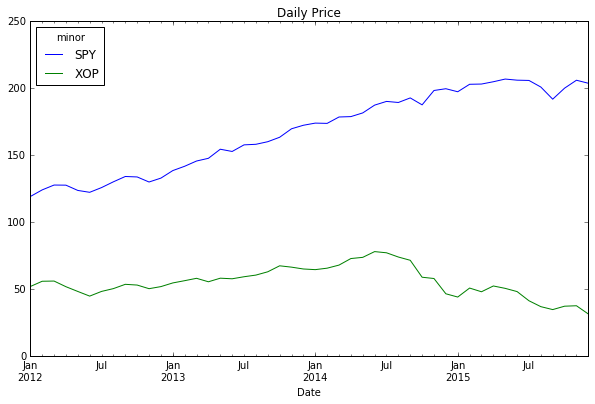

In [61]:
#Basic visualization of the fund data -- daily price
dm.plot(kind='line',figsize = (10,6), title = 'Daily Price')
#now this chart doesn't really tell you anything useful as the price of two ETF deviates

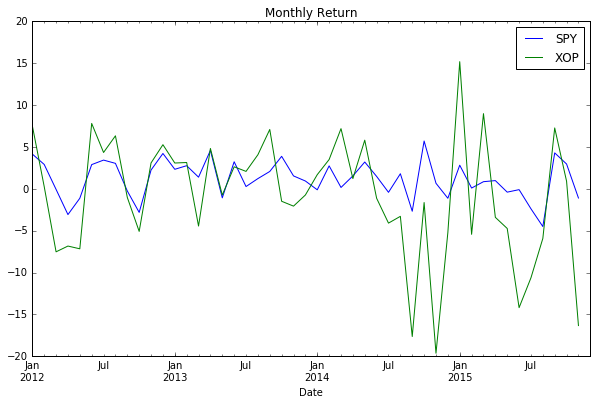

In [60]:
#Basic visualization of the fund data -- monthly return
dmpct1.plot(kind='line',figsize = (10,6), title='Monthly Return') 
#the monthly return chart is much more informative as it eliminates the level effect of prices 
#as you can see, XOP(green)is a lot more volatile comparing to the market return 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C5AEE80438>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001C5AF033400>], dtype=object)

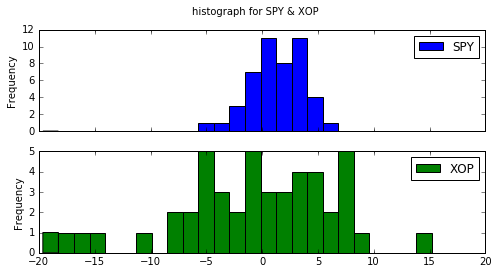

In [65]:
dmpct1.plot(kind='hist',subplots=True, figsize = (8,4),bins = 25,title="histograph for SPY & XOP")
# we can use histogram to see the distribution of returns for the S&P 500 comparing to the fund we are using
# It is clear that XOP has more losses than S&P 500 ...not a good sign if you want to make money 

## Basic performance analysis 

In [49]:
print(dmpct1.mean())  #average return for the fund
print(dmpct1.std())   #average standard deviation for the fund

SPY    1.171915
XOP   -0.791915
dtype: float64
SPY    2.262183
XOP    7.251199
dtype: float64


## Read in data from Ken French data library 

Now we need to perform a basic factor regression to see how the ETF correlates with the factors (Market, SMB, HML)

**Market(Market - Rf)**       --> excess return on the market 

**SMB: (Small minue Big)**    --> Trade on small firms versus big firms in market cap 

**HML: (High minus Low)**     --> Trade on high B/M ratio companies versus low B/M companies 

In [50]:
ff = DataReader('F-F_Research_Data_Factors', 'famafrench')[0]
ff.columns = ['Market', 'SMB', 'HML', 'Rf'] #rename the columns to make it easier to understand 
ff.head()

ff1=ff[ff.index >= 201201]  #this is to keep the time series of factors and ETF returns consistent 
ff1.head()

,Market,SMB,HML,Rf
201201,5.05,2.51,-2.14,0.00
201202,4.42,-1.65,0.01,0.00
201203,3.11,-0.27,-0.06,0.00
201204,-0.85,-0.63,-0.20,0.00
201205,-6.19,-0.11,0.08,0.01


## Linear Regression

In [51]:
import statsmodels.formula.api as smf  #introduce the regression package 
ff1.index = range(1,len(ff1) + 1) 
dmpct1.index = range(1,len(dmpct1) + 1) #I need to reset the index of both to merge the databases corrrectly 
combine = pd.concat([dmpct1, ff1], axis=1) #This step allows me to have the returns and factors alligned nicely
combine.head()

,SPY,XOP,Market,SMB,HML,Rf
1,4.15,7.54,5.05,2.51,-2.14,0.00
2,2.91,0.27,4.42,-1.65,0.01,0.00
3,-0.07,-7.53,3.11,-0.27,-0.06,0.00
4,-3.08,-6.84,-0.85,-0.63,-0.20,0.00
5,-1.13,-7.17,-6.19,-0.11,0.08,0.01


In [52]:
combine['Excess'] = combine['XOP']- combine['Rf']  
# After combining two dataset, I need to get excess market return for the given fund/ETF
combine.head()

,SPY,XOP,Market,SMB,HML,Rf,Excess
1,4.15,7.54,5.05,2.51,-2.14,0.00,7.54
2,2.91,0.27,4.42,-1.65,0.01,0.00,0.27
3,-0.07,-7.53,3.11,-0.27,-0.06,0.00,-7.53
4,-3.08,-6.84,-0.85,-0.63,-0.20,0.00,-6.84
5,-1.13,-7.17,-6.19,-0.11,0.08,0.01,-7.18


In [53]:
model = smf.ols(formula = 'Excess ~ Market + SMB + HML', data = combine).fit()     #Fits the linear regression model
print(model.summary())  #Prints off a nice summary!

                            OLS Regression Results                            
Dep. Variable:                 Excess   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.9308
Date:                Wed, 11 May 2016   Prob (F-statistic):              0.434
Time:                        17:07:57   Log-Likelihood:                -157.82
No. Observations:                  47   AIC:                             323.6
Df Residuals:                      43   BIC:                             331.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.0319      1.155     -0.894      0.3

In [54]:
result = pd.DataFrame(model.params)
result.columns = ['XOP']
result

,XOP
Intercept,-1.031915
Market,0.260921
SMB,0.319233
HML,0.824092


## Calculate Sharpe Ratio
The sharpe ratio is commonly used to measure risk-adjusted return for given asset

** Sharpe ratio = (Mean asset return − Risk-free rate)/Standard deviation of asset return **

It measure the excess return per unit of additional risk. It can be positive, negative or zero(risk free) given the underlying asset. 

In [55]:
print('Average excess return: ',combine['Excess'].mean())
print('Standard deviation: ',combine['Excess'].std())
Sharpe = combine['Excess'].mean()/combine['Excess'].std()  #we are using average excess return on the fund as calculated above
print ('Sharpe Ratio: ',Sharpe)

Average excess return:  -0.7931914893617021
Standard deviation:  7.251014953359222
Sharpe Ratio:  -0.10939040871709076


In [56]:
result.loc['Sharpe Ratio']= Sharpe    # now we can use loc to add sharpe ratio into our regression result dataframe
result

,XOP
Intercept,-1.031915
Market,0.260921
SMB,0.319233
HML,0.824092
Sharpe Ratio,-0.109390


## Conclusion

**For XOP:  **

This ETF is not a very good investment as indicated by the negative sharpe ratio and -1% alpha. 

A negative sharpe ratio would suggest that you are better off investing in a risk free bond than putting your money into the ETF. 

However, the ETF may still have diverfication value in a portfolio context given its low correlation to the overall market. 


**For the project: **

The code above can efficiently run fund regression one at a time. The next step would be to re-model the code into a loop strcture so it can reads in a list of tickers and perform the same function repeatedly. It will provide a similar table like the final result above but with more columns. 

The idea is that you can quickly screen a set of mutual funds with similar strategy and investment scope. The result table would allow you to screen for the best performing fund in the subset easily.

**More on the subject: **

Theoractically, this can also be replicated for the Chinese fund analysis without the use of proprietary database CSMARS.

You can extract mutual fund data from: [Chinese Securities Regulatory Commission Fund Disclosure](http://fund.csrc.gov.cn/web/list_net.daily_report?1=1&fundCode=000001&limit=20&start=0) with a web-scraping loop. 

I cannot perform the analysis because I didn't know how to constrcut the fama-french factors for Chinese stock market